# 4.2 
## 4.2.1 画出一个sin(x)图


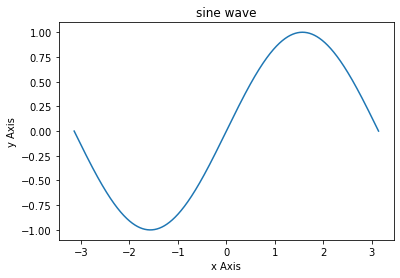

In [87]:
import matplotlib.pyplot as plt
import numpy as np

def graph_frame(title: str, total_dot): #基本图线
    plt.xlabel('x Axis')
    plt.ylabel('y Axis')
    plt.title(title)
    lx = np.linspace(-np.pi,np.pi,total_dot)
    plt.plot(lx,np.sin(lx), label = 'real sound')
    return lx

total_dot = 1000
lx = graph_frame('sine wave', total_dot)
lx_r = lx.reshape([total_dot, 1])

plt.show()

## 4.2.2 选取一些点并加入高斯噪声

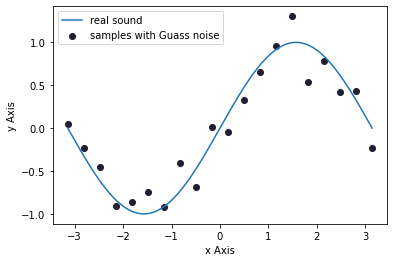

In [88]:
def guass_noise(signal, n: int, SNR): # 对指定信号数组输入signal, n和信噪比SNR产生高斯噪声
    noise = np.random.randn(n)
    noise = noise - np.mean(noise)    # 无偏化
    signal_power = np.linalg.norm(signal)**2
    noise_variance = signal_power/np.power(10,(SNR/10))
    noise = (np.sqrt(noise_variance)/np.std(noise))*noise
    return noise

def sample_generator(begin, end, n, func, SNR = 24):    # 在指定区域[begin:end]上平均选取n个点，
    np.random.seed(1279)                                # 取这n个位置上的信号值func()并混入信噪比为SNR的高斯噪声
    x = np.linspace(begin, end, n)                      # 调用该函数将在图上绘出采样点，并返回采样组(x, y)
    y = func(x) + guass_noise(func(x), n, SNR)
    plt.scatter(x, y, color = '#1f1e33', label = 'samples with Guass noise')
    return (x.reshape([n,1]), y)

graph_frame('', 1000)

n_sample_dot = 20 # 选取20个数据点
x, y = sample_generator(-np.pi,np.pi,n_sample_dot, np.sin)
plt.legend(loc = 'upper left')

## 4.2.3用sklearn的回归模型对噪声点进行拟合

分别采用3阶，9阶，20阶多项式回归进行拟合


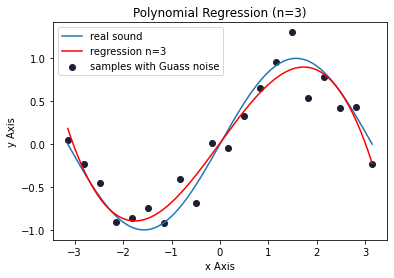

In [89]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

def poly_reg(degree): # 多项式回归模型
    return Pipeline([
        ("poly", PolynomialFeatures(degree=degree)),
        ("std_scaler", StandardScaler()),
        ("lin_reg", LinearRegression())
    ])


graph_frame('Polynomial Regression (n=3)', total_dot)

n_sample_dot = 20
(x, y) = sample_generator(-np.pi, np.pi, n = n_sample_dot, func = np.sin)
reg = poly_reg(degree = 3)
reg.fit(x, y)
plt.plot(lx, reg.predict(lx_r), color = 'red', label = 'regression n=3')
plt.legend(loc = 'upper left')

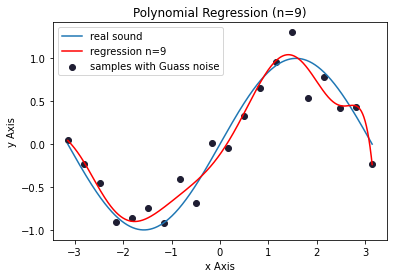

In [90]:
graph_frame('Polynomial Regression (n=9)', total_dot)

n_sample_dot = 20
(x, y) = sample_generator(-np.pi, np.pi, n = n_sample_dot, func = np.sin)
reg = poly_reg(degree = 9)
reg.fit(x, y)
plt.plot(lx, reg.predict(lx_r), color = 'red', label = 'regression n=9')
plt.legend(loc = 'upper left')

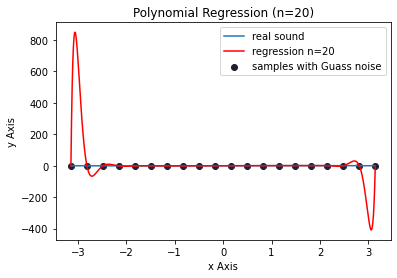

In [91]:
graph_frame('Polynomial Regression (n=20)', total_dot)

n_sample_dot = 20
(x, y) = sample_generator(-np.pi, np.pi, n = n_sample_dot, func = np.sin)
reg = poly_reg(degree = 20)
reg.fit(x, y)
plt.plot(lx, reg.predict(lx_r), color = 'red', label = 'regression n=20')
plt.legend(loc = 'upper right')

其实可以发现3阶的回归拟合得已经不错了

由于数据点较少，更高阶的多项式回归反而造成了过拟合(over-fitting)，使得所求得的曲线充满了**锯齿**而不再**光滑**

```
注意20阶的回归(这里就是简单的插值，发生了龙格现象)，结果完全偏离了原函数，是明显的过拟合
```

这表明对于这个问题而言，三次多项式是一个较为不错的模型，同时也告诉我们并非越复杂的模型越好(可能会造成过拟合)


## 5.1 更多的采样点（附加题）

更多的数据点能够缓解由于训练数据过少造成的过拟合现象

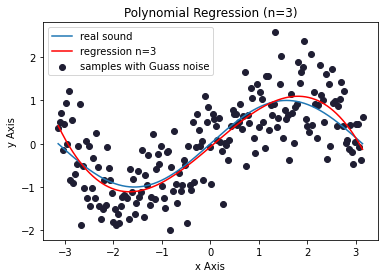

In [92]:
n_sample_dot = 200

graph_frame('Polynomial Regression (n=3)', total_dot)

(x, y) = sample_generator(-np.pi, np.pi, n = n_sample_dot, func = np.sin)
reg = poly_reg(degree = 3)
reg.fit(x, y)
plt.plot(lx, reg.predict(lx_r), color = 'red', label = 'regression n=3')
plt.legend()

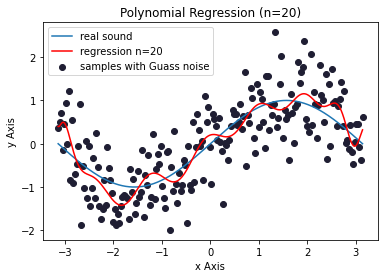

In [93]:
n_sample_dot = 200

graph_frame('Polynomial Regression (n=20)', total_dot)

(x, y) = sample_generator(-np.pi, np.pi, n = n_sample_dot, func = np.sin)
reg = poly_reg(degree = 20)
reg.fit(x, y)
plt.plot(lx, reg.predict(lx_r), color = 'red', label = 'regression n=20')
plt.legend()

增大了采样点的数量后，低阶拟合与高阶拟合的结果都有了一定的改善

可以明显看到20阶回归的过拟合情况有了较大的改善，不过3阶回归的结果仍然明显优于20阶回归

这至少说明在模型选择的时候并非越高阶越复杂越好，而是应该有所取舍，根据适当的先验假设建立更为可靠的模型

另外，大量数据的加入能够一定程度上抵消掉坏模型和好模型之间的差距；
反过来看，也可以说：好的模型可以使得我们花费更少的数据获得同样水平的结果

----------------------------

不过这只是这个局部而言的，如果扩展x的取值范围，在更大的范围内做拟合，那么更高阶的模型会更合适

## 5.2 正则化（附加题）

采用正则化的方法来减轻高阶回归的过拟合现象

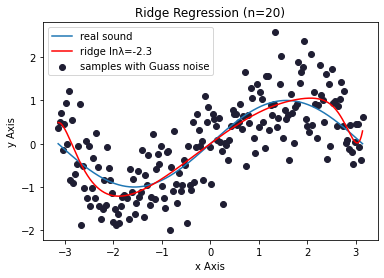

In [94]:
# 岭回归
from sklearn.linear_model import Ridge 

def RidgeRegression(degree, alpha): # 岭回归模型
    return Pipeline([
        ("poly", PolynomialFeatures(degree=degree)),
        ("std_scaler", StandardScaler()),
        ("ridge_reg", Ridge(alpha=alpha))
    ])

graph_frame('Ridge Regression (n=20)', total_dot)
(x, y) = sample_generator(-np.pi, np.pi, n = n_sample_dot, func = np.sin)
ridge_reg = RidgeRegression(degree = 20, alpha = 0.1)
ridge_reg.fit(x, y)

plt.plot(lx,ridge_reg.predict(lx_r), color = 'red', label = 'ridge lnλ=-2.3')
plt.legend()

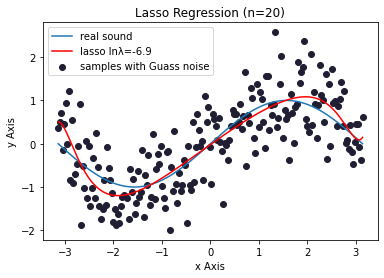

In [95]:
# LASSO 回归
from sklearn.linear_model import Lasso

def LassoRegression(degree, alpha): #Lasso回归模型
    return Pipeline([
        ("poly", PolynomialFeatures(degree=degree)),
        ("std_scaler", StandardScaler()),
        ("lasso_reg", Lasso(alpha=alpha))
    ])

graph_frame('Lasso Regression (n=20)', total_dot)
(x, y) = sample_generator(-np.pi, np.pi, n = n_sample_dot, func = np.sin)
lasso_reg = LassoRegression(degree = 20, alpha = 0.001)
lasso_reg.fit(x, y)

plt.plot(lx,lasso_reg.predict(lx_r), color = 'red', label = 'lasso lnλ=-6.9')
plt.legend()

从图中可以看出，经过正规化后，多项式回归的过拟合现象显著改善，图线重新变得平滑

另外L1正规化和L2正规化相比，L1的平滑能力更强，所需的惩罚常量λ更小


----------------------

全部是现学现卖（ 

----------------------